# Analisando os dados

> Esse notebook faz uma análise exploratória dos dados

Ele não é o único a armazenar as visualizações a serem desenvolvidas nesse projeto, mas será um bom ponto de partida para entender os dados que estão sendo utilizados.

In [1]:
from pathlib import Path
from sentence_transformers import SentenceTransformer
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE
import umap
import pandas as pd
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import community as community_louvain
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import nltk
import re
import sys
import math

# --- 1. Preparação do NLTK (Stopwords) ---
try:
    # Tenta encontrar o pacote de stopwords
    nltk.data.find('corpora/stopwords')
except LookupError:
    # Se não encontrar, baixa
    print("Baixando pacote 'stopwords' do NLTK...")
    nltk.download('stopwords')

from nltk.corpus import stopwords

# Carrega as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))

# Adiciona palavras de contexto que queremos ignorar
stopwords_pt.update([
    'nan', 'none', 'null', 'projeto', 'proposta',
    'objetivo', 'justificativa', 'conteudo', 'disciplina', 'curso',
    'aluno', 'alunos', 'professor', 'professores', 'através', 'ser',
    'uso', 'desenvolvimento', 'conceitos', 'prática', 'teoria'
])
print("Stopwords do NLTK carregadas com sucesso.")

PALETA_PAUL_TOL_6 = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

/home/italo/open/viz-disciplinas-usp/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Stopwords do NLTK carregadas com sucesso.


## Carregando os dados

In [2]:
scrap_file = Path('output.pickle')

In [3]:
assert scrap_file.exists(), "Arquivo com dados raspados não foi encontrado. Verifique que o notebook 00_data_preprocessing.ipynb foi executado."

In [4]:
df = pd.read_pickle(scrap_file)
df.head()

codigo                                         disciplina    criacao  \
0  DCV5969                 Projeto de Reforma do Código Civil 2024-05-22   
1  DCV5963  Direito Notarial e Registral: Novas Perspectiv... 2021-11-17   
2  DCV5962                 Temas Atuais de Família e Sucessão 2021-05-03   
3  DCV5961              Direito da Arte e Patrimônio Cultural 2023-06-28   
4  DCV5955              Dogmática e Crítica da Jurisprudência 2025-04-23   

   n_creditos  carga_teorica  carga_pratica  carga_estudo  duracao  \
0           8              2              2             4     2520   
1           8              2              2             4     2520   
2           8              2              2             4     2520   
3           8              2              2             4     2520   
4           8              2              2             4     2520   

   carga_total                              docentes_responsaveis  ...  \
0          120                                                     ...   
1          120                                                     ...   
2          120  Claudio Luiz Bueno de Godoy | Fernando Campos ...  ...   
3          120  Silmara Juny de Abreu Chinellato | Antonio Car...  ...   
4          120  Alexandre de Moraes | Otavio Luiz Rodrigues Ju...  ...   

                                            conteudo  \
0  1) Codificar ou não codificar? Eis a questão; ...   
1  A disciplina será estruturada em aulas exposit...   
2  A disciplina será formada tanto por aulas expo...   
3  Ementa \nDireito da Arte. Multidisciplinarieda...   
4  §1 Introdução e apresentação da disciplina. §2...   

                                        bibliografia     idioma oferecimento  \
0  BIANCA, Cesare Massimo.  L'obbligazione nelle ...  Português   Presencial   
1  ALVIM NETO, José Manoel Arruda; CLÁPIS, Alexan...  Português   Presencial   
2  ABRAMS, Douglas E., Contemporary Family Law, 4...  Português   Presencial   
3  ASCENSÃO, José de Oliveira. Direito autoral. 2...  Português   Presencial   
4  ÁVILA, Humberto. “Neoconstitucionalismo”: entr...  Português   Presencial   

  codigo_area_concentracao area_concentracao codigo_commissao  \
0                     2131     Direito Civil                2   
1                     2131     Direito Civil                2   
2                     2131     Direito Civil                2   
3                     2131     Direito Civil                2   
4                     2131     Direito Civil                2   

              commissao codigo_programa  nome_programa  
0  Faculdade de Direito            2001        Direito  
1  Faculdade de Direito            2001        Direito  
2  Faculdade de Direito            2001        Direito  
3  Faculdade de Direito            2001        Direito  
4  Faculdade de Direito            2001        Direito  

[5 rows x 23 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2213 entries, 0 to 2244
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   codigo                    2213 non-null   object        
 1   disciplina                2213 non-null   object        
 2   criacao                   2213 non-null   datetime64[ns]
 3   n_creditos                2213 non-null   int64         
 4   carga_teorica             2213 non-null   int64         
 5   carga_pratica             2213 non-null   int64         
 6   carga_estudo              2213 non-null   int64         
 7   duracao                   2213 non-null   int64         
 8   carga_total               2213 non-null   int64         
 9   docentes_responsaveis     2213 non-null   object        
 10  objetivos                 2213 non-null   object        
 11  justificativa             2213 non-null   object        
 12  avaliacao                

## Análise

In [6]:
df_analise = df[df.nome_programa == "Ciências de Computação e Matemática Computacional"]

### 1ª pergunta

Qual é a estrutura temática incluída no currículo do PPG-CCMC? É possível,
analisando semanticamente os objetivos e as justificativas das disciplinas, ir além dos códigos e nomes
formais para:
1. Identificar pares de disciplinas com alta sobreposição?
2. Revelar grandes grupos temáticos, ou trilhas de conhecimento que compõem o
programa?

#### Embedding

In [7]:
def gerar_embeddings_em_colunas(df: pd.DataFrame, coluna_texto: str, nome_modelo: str = 'all-mpnet-base-v2') -> pd.DataFrame:
    """
    Gera embeddings para uma coluna de texto e os adiciona como colunas separadas
    no DataFrame, cada uma com um prefixo.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        coluna_texto (str): O nome da coluna que contém os textos a serem processados.
        nome_modelo (str): O nome do modelo Sentence Transformer a ser usado.

    Returns:
        pd.DataFrame: O DataFrame original com as novas colunas de embedding.
    """
    print(f"Carregando o modelo '{nome_modelo}'... Isso pode levar um momento.")
    try:
        model = SentenceTransformer(nome_modelo)
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        print("Verifique sua conexão com a internet ou o nome do modelo.")
        return df

    print("Gerando embeddings... Por favor, aguarde.")

    # 1. Garante que a coluna de texto não tenha valores nulos (NaN)
    textos = df[coluna_texto].fillna('').tolist()

    # 2. Gera os embeddings (isso retorna um array NumPy)
    embeddings = model.encode(textos, show_progress_bar=True)

    # 3. Define o prefixo para as novas colunas
    prefixo = f'{coluna_texto}_embed_'

    # 4. Cria um novo DataFrame a partir do array de embeddings
    embeddings_df = pd.DataFrame(embeddings)

    # 5. Adiciona o prefixo desejado às colunas (ex: 0 -> 'coluna_texto_0')
    embeddings_df = embeddings_df.add_prefix(prefixo)

    # 6. Garante que o índice do novo DataFrame de embeddings seja o mesmo
    #    do DataFrame original para um 'join' correto.
    embeddings_df.index = df.index

    # 7. Concatena o DataFrame original com o DataFrame de embeddings (lado a lado)
    df_final = pd.concat([df, embeddings_df], axis=1)

    print(f"Embeddings gerados e adicionados como {embeddings_df.shape[1]} colunas com prefixo '{prefixo}'.")
    return df_final



#### Redução de Dimensionalidade

Gerando os embeddings para que seja possível transformar o texto de cada disciplina em um vetor de números reais

In [8]:
df_embbed = gerar_embeddings_em_colunas(df=df_analise, coluna_texto='objetivos')
df_embbed = gerar_embeddings_em_colunas(df=df_embbed, coluna_texto='justificativa')
df_embbed = gerar_embeddings_em_colunas(df=df_embbed, coluna_texto='conteudo')

Carregando o modelo 'all-mpnet-base-v2'... Isso pode levar um momento.
Gerando embeddings... Por favor, aguarde.


Batches: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


Embeddings gerados e adicionados como 768 colunas com prefixo 'objetivos_embed_'.
Carregando o modelo 'all-mpnet-base-v2'... Isso pode levar um momento.
Gerando embeddings... Por favor, aguarde.


Batches: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.08s/it]


Embeddings gerados e adicionados como 768 colunas com prefixo 'justificativa_embed_'.
Carregando o modelo 'all-mpnet-base-v2'... Isso pode levar um momento.
Gerando embeddings... Por favor, aguarde.


Batches: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.73s/it]

Embeddings gerados e adicionados como 768 colunas com prefixo 'conteudo_embed_'.


Duas abordagens serão utilizadas para visualizar a clusterização. t-SNE e UMAP como técnicas de redução de dimensionalidade para que os textos das disciplinas possam ser visualizadas em 2D e criação de um grafo via kNN e aplicar o método de Louvain para encontrar comunidades.

In [9]:
def aplicar_tsne_e_plotar(df: pd.DataFrame,
                          coluna_texto: str,
                          n_components: int = 2,
                          plotar_resultado: bool = True,
                          coluna_cor: str = None,
                          colunas_hover: list = None,
                          filename: str | None = None,
                          **tsne_params) -> pd.DataFrame:

    prefixo_embedding = f'{coluna_texto}_embed_'
    colunas_embedding = [col for col in df.columns if col.startswith(prefixo_embedding)]
    if not colunas_embedding:
        print(f"Erro: Nenhuma coluna de embedding encontrada com o prefixo '{prefixo_embedding}'.")
        return df
    print(f"Encontradas {len(colunas_embedding)} colunas de embedding para '{coluna_texto}'.")
    embeddings_data = df[colunas_embedding].fillna(0)

    print(f"Aplicando t-SNE (n_components={n_components})...")
    params = {'random_state': 42}
    params.update(tsne_params)
    tsne = TSNE(n_components=n_components, **params)
    embeddings_tsne = tsne.fit_transform(embeddings_data)

    colunas_tsne_nomes = [f'tsne_{coluna_texto}_{i+1}' for i in range(n_components)]
    df_tsne = pd.DataFrame(embeddings_tsne, columns=colunas_tsne_nomes, index=df.index)
    df_final = pd.concat([df, df_tsne], axis=1)
    print(f"Colunas t-SNE adicionadas: {', '.join(colunas_tsne_nomes)}")

    if filename is None:
        filename = f"tsne-{coluna_texto}.png"

    if plotar_resultado:
        if n_components < 2:
            print("Plotagem pulada: t-SNE precisa de n_components >= 2 para plotar.")
            return df_final

        x_col = colunas_tsne_nomes[0]
        y_col = colunas_tsne_nomes[1]

        if colunas_hover is None: colunas_hover = [coluna_texto]
        hover_data_valido = [col for col in colunas_hover if col in df_final.columns]

        cor_valida = None
        cat_order_dict = None
        if coluna_cor and coluna_cor in df_final.columns:
            cor_valida = coluna_cor
            # --- CORREÇÃO DA ORDEM ---
            # Garante que a legenda seja ordenada numericamente (0, 1, 2, 3...)
            categorias_ordenadas = sorted(df_final[coluna_cor].unique())
            cat_order_dict = {coluna_cor: categorias_ordenadas}
            # --- FIM DA CORREÇÃO ---

        print("Gerando gráfico interativo com Plotly...")
        fig = px.scatter(
            df_final,
            x=x_col,
            y=y_col,
            color=cor_valida,
            hover_data=hover_data_valido,
            title=f'Visualização t-SNE dos Embeddings de "{coluna_texto}"',
            template="plotly_white",
            color_discrete_sequence=PALETA_PAUL_TOL_6,
            category_orders=cat_order_dict # <--- FORÇA A ORDEM DA LEGENDA
        )

        fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')))
        fig.update_layout(xaxis_title="Componente t-SNE 1", yaxis_title="Componente t-SNE 2")
        fig.show()
        fig.write_image(filename)

    return df_final

In [10]:
def aplicar_umap_e_plotar(df: pd.DataFrame,
                          coluna_texto: str,
                          n_components: int = 2,
                          plotar_resultado: bool = True,
                          coluna_cor: str = None,
                          colunas_hover: list = None,
                          filename: str | None = None,
                          **umap_params) -> pd.DataFrame:

    prefixo_embedding = f'{coluna_texto}_embed_'
    colunas_embedding = [col for col in df.columns if col.startswith(prefixo_embedding)]
    if not colunas_embedding:
        print(f"Erro: Nenhuma coluna de embedding encontrada com o prefixo '{prefixo_embedding}'.")
        return df
    print(f"Encontradas {len(colunas_embedding)} colunas de embedding para '{coluna_texto}'.")
    embeddings_data = df[colunas_embedding].fillna(0)

    print(f"Aplicando UMAP (n_components={n_components})...")
    params = {'random_state': 42}
    params.update(umap_params)
    try:
        reducer = umap.UMAP(n_components=n_components, **params)
    except NameError:
        print("Erro: A classe umap.UMAP() não está disponível. 'umap-learn' está instalado?")
        return df
    embeddings_umap = reducer.fit_transform(embeddings_data)

    colunas_umap_nomes = [f'umap_{coluna_texto}_{i+1}' for i in range(n_components)]
    df_umap = pd.DataFrame(embeddings_umap, columns=colunas_umap_nomes, index=df.index)
    df_final = pd.concat([df, df_umap], axis=1)
    print(f"Colunas UMAP adicionadas: {', '.join(colunas_umap_nomes)}")

    if filename is None:
        filename = f"umap-{coluna_texto}.png"

    if plotar_resultado:
        if n_components < 2:
            print("Plotagem pulada: UMAP precisa de n_components >= 2 para plotar.")
            return df_final

        x_col = colunas_umap_nomes[0]
        y_col = colunas_umap_nomes[1]

        if colunas_hover is None: colunas_hover = [coluna_texto]
        hover_data_valido = [col for col in colunas_hover if col in df_final.columns]

        cor_valida = None
        cat_order_dict = None
        if coluna_cor and coluna_cor in df_final.columns:
            cor_valida = coluna_cor
            # --- CORREÇÃO DA ORDEM ---
            # Garante que a legenda seja ordenada numericamente (0, 1, 2, 3...)
            categorias_ordenadas = sorted(df_final[coluna_cor].unique())
            cat_order_dict = {coluna_cor: categorias_ordenadas}
            # --- FIM DA CORREÇÃO ---

        print("Gerando gráfico interativo com Plotly...")
        fig = px.scatter(
            df_final,
            x=x_col,
            y=y_col,
            color=cor_valida,
            hover_data=hover_data_valido,
            title=f'Visualização UMAP dos Embeddings de "{coluna_texto}"',
            template="plotly_white",
            color_discrete_sequence=PALETA_PAUL_TOL_6,
            category_orders=cat_order_dict # <--- FORÇA A ORDEM DA LEGENDA
        )

        fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')))
        fig.update_layout(xaxis_title="Componente UMAP 1", yaxis_title="Componente UMAP 2")
        fig.show()
        fig.write_image(filename)

    return df_final

Encontradas 768 colunas de embedding para 'objetivos'.
Aplicando t-SNE (n_components=2)...
Colunas t-SNE adicionadas: tsne_objetivos_1, tsne_objetivos_2
Gerando gráfico interativo com Plotly...


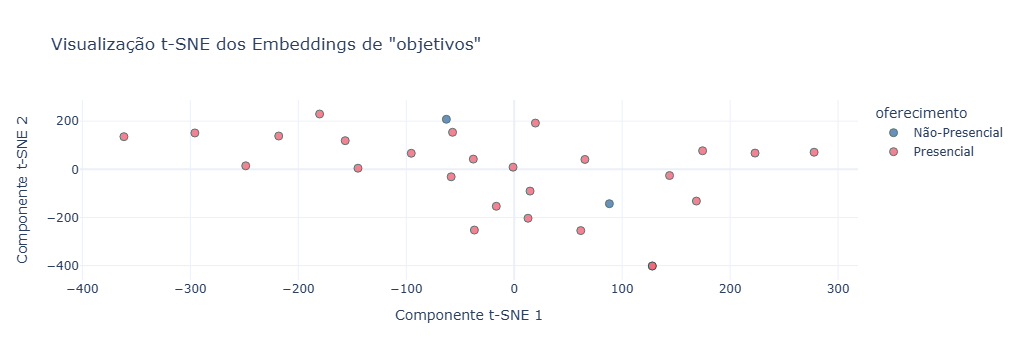

Encontradas 768 colunas de embedding para 'justificativa'.
Aplicando t-SNE (n_components=2)...
Colunas t-SNE adicionadas: tsne_justificativa_1, tsne_justificativa_2
Gerando gráfico interativo com Plotly...


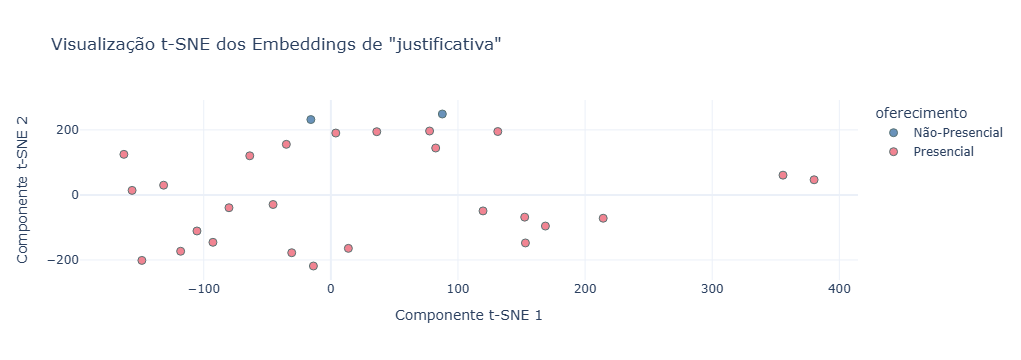

Encontradas 768 colunas de embedding para 'conteudo'.
Aplicando t-SNE (n_components=2)...
Colunas t-SNE adicionadas: tsne_conteudo_1, tsne_conteudo_2
Gerando gráfico interativo com Plotly...


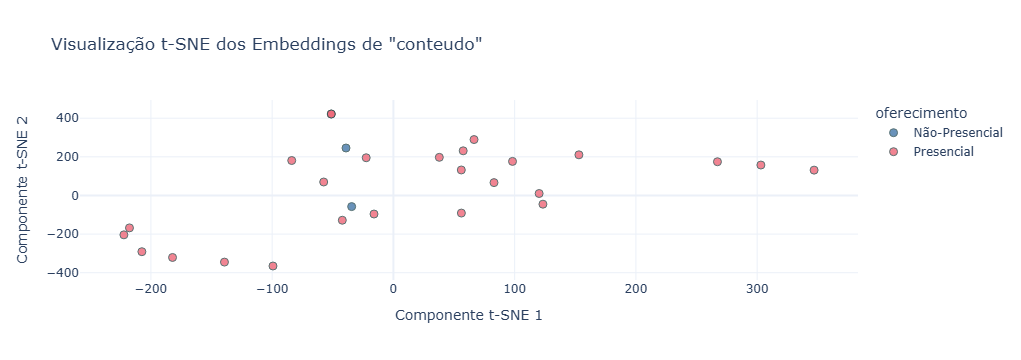

In [11]:
df_final = aplicar_tsne_e_plotar(
    df_embbed,
    coluna_texto='objetivos',
    n_components=2,
    perplexity=6,
    plotar_resultado=True,
    coluna_cor='oferecimento',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="tsne-embeddings-objetivos.png"
)

df_final = aplicar_tsne_e_plotar(
    df_embbed,
    coluna_texto='justificativa',
    n_components=2,
    perplexity=3,plotar_resultado=True,
    coluna_cor='oferecimento',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="tsne-embeddings-justificativa.png"
)

df_final = aplicar_tsne_e_plotar(
    df_embbed,
    coluna_texto='conteudo',
    n_components=2,
    perplexity=3,
    plotar_resultado=True,
    coluna_cor='oferecimento',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="tsne-embeddings-conteudo.png"
)

In [12]:
df_final = aplicar_umap_e_plotar(
    df_embbed,
    coluna_texto='objetivos',
    n_components=2,
    n_neighbors=5,
    plotar_resultado=True,
    coluna_cor='oferecimento',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="umap-embeddings-objetivos.png"
)

df_final = aplicar_umap_e_plotar(
    df_embbed,
    coluna_texto='justificativa',
    n_components=2,
    n_neighbors=5,
    plotar_resultado=True,
    coluna_cor='oferecimento',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="umap-embeddings-justificativa.png"
)

df_final = aplicar_umap_e_plotar(
    df_embbed,
    coluna_texto='conteudo',
    n_components=2,
    n_neighbors=5,
    plotar_resultado=True,
    coluna_cor='oferecimento',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="umap-embeddings-conteudo.png"
)

Encontradas 768 colunas de embedding para 'objetivos'.
Aplicando UMAP (n_components=2)...


/home/italo/open/viz-disciplinas-usp/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Colunas UMAP adicionadas: umap_objetivos_1, umap_objetivos_2
Gerando gráfico interativo com Plotly...


Resorting to unclean kill browser.


Encontradas 768 colunas de embedding para 'justificativa'.
Aplicando UMAP (n_components=2)...
Colunas UMAP adicionadas: umap_justificativa_1, umap_justificativa_2
Gerando gráfico interativo com Plotly...


/home/italo/open/viz-disciplinas-usp/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Encontradas 768 colunas de embedding para 'conteudo'.
Aplicando UMAP (n_components=2)...
Colunas UMAP adicionadas: umap_conteudo_1, umap_conteudo_2
Gerando gráfico interativo com Plotly...


/home/italo/open/viz-disciplinas-usp/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



#### Redes Complexas

In [13]:
def criar_grafo_knn_embeddings(df: pd.DataFrame,
                               coluna_texto: str,
                               k: int = 5) -> nx.Graph:
    """
    Cria um grafo NetworkX conectando cada item aos seus 'k' vizinhos
    mais próximos, com base nas colunas de embedding.

    Args:
        df (pd.DataFrame): DataFrame com as colunas de embedding (ex: 'coluna_embed_0').
        coluna_texto (str): O nome da coluna *original* (ex: 'objetivos').
        k (int): O número de vizinhos para conectar.

    Returns:
        nx.Graph: Um grafo NetworkX onde os nós são o índice do DataFrame.
    """

    # 1. Encontra as colunas de embedding
    prefixo_embedding = f'{coluna_texto}_embed_'
    colunas_embedding = [col for col in df.columns if col.startswith(prefixo_embedding)]

    if not colunas_embedding:
        print(f"Erro: Nenhuma coluna de embedding encontrada com o prefixo '{prefixo_embedding}'.")
        return None

    print(f"Encontradas {len(colunas_embedding)} colunas de embedding para '{coluna_texto}'.")
    embeddings_data = df[colunas_embedding].fillna(0)

    # 2. Configura e treina o NearestNeighbors
    # Usamos 'k+1' porque o vizinho mais próximo de um ponto é ele mesmo (distância 0)
    # Usamos 'cosine' como métrica, que é padrão para embeddings de texto
    print(f"Encontrando os {k} vizinhos mais próximos (usando métrica 'cosine')...")
    nn = NearestNeighbors(n_neighbors=k + 1, metric='cosine', n_jobs=-1)
    nn.fit(embeddings_data)

    # distances: distâncias
    # indices: os índices (posições) dos vizinhos no array de embeddings
    distances, indices = nn.kneighbors(embeddings_data)

    # 3. Constrói o grafo
    print("Construindo o grafo...")
    G = nx.Graph()

    # Adiciona todos os nós ao grafo. Os nós serão o ÍNDICE do DataFrame.
    G.add_nodes_from(df.index)

    # Itera sobre cada ponto (linha do df)
    for i in range(len(indices)):
        source_node = df.index[i]

        # Pega os vizinhos (começa do 1 para pular o próprio ponto)
        for j in range(1, k + 1):
            neighbor_pos = indices[i][j]
            neighbor_dist = distances[i][j]

            # Pega o rótulo do nó (índice do df)
            target_node = df.index[neighbor_pos]

            # Adiciona a aresta com a distância como 'peso'
            # (Usamos 1 - dist para que 'similaridade' seja o peso, opcional)
            G.add_edge(source_node, target_node, weight=neighbor_dist)

    print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")
    return G


def detectar_comunidades_louvain(df: pd.DataFrame,
                                 G: nx.Graph,
                                 coluna_texto: str,
                                 random_state: int = 42) -> pd.DataFrame:
    """
    Detecta comunidades em um grafo usando o algoritmo Louvain e adiciona
    os rótulos das comunidades ao DataFrame.

    Args:
        df (pd.DataFrame): DataFrame original.
        G (nx.Graph): O grafo gerado pela função 'criar_grafo_knn_embeddings'.
        coluna_texto (str): O nome da coluna base (ex: 'objetivos') para
                             nomear a nova coluna de comunidade.
        random_state (int): Para reprodutibilidade do algoritmo.

    Returns:
        pd.DataFrame: O DataFrame original com a nova coluna de comunidade.
    """

    if G is None:
        print("Erro: O grafo de entrada é Nulo. Abortando.")
        return df

    print("Aplicando o algoritmo de comunidade Louvain...")

    # 1. Executa o 'best_partition' do Louvain
    # Isso retorna um dicionário {node: community_id}
    # Os 'nodes' aqui são os índices do DataFrame (ex: 0, 1, 2...)
    partition = community_louvain.best_partition(G, random_state=random_state)

    # 2. Converte o dicionário de partição em uma coluna do DataFrame
    nova_coluna = f'comunidade_{coluna_texto}'

    # Mapeia os IDs da comunidade para o índice do DataFrame
    # 'partition.get(idx)' garante que, se um nó do df não estiver na partição,
    # ele receba NaN (embora isso não deva acontecer se G foi bem formado).
    df[nova_coluna] = df.index.map(partition)

    # 3. Finalização
    n_comunidades = df[nova_coluna].nunique()
    print(f"Detecção concluída. Encontradas {n_comunidades} comunidades.")
    print(f"Nova coluna adicionada: '{nova_coluna}'")

    # Converter para 'category' é uma boa prática para rótulos de cluster
    df[nova_coluna] = df[nova_coluna].astype('category')

    return df



In [14]:
def plotar_grafo_interativo(G: nx.Graph,
                            df: pd.DataFrame,
                            coluna_cor: str = None,
                            colunas_hover: list = None,
                            titulo: str = 'Grafo Interativo de Similaridade'):

    print("Calculando layout do grafo (spring_layout)...")
    pos = nx.spring_layout(G, seed=42, k=0.3)

    # 1. Preparar o Trace das Arestas (Edges)
    edge_x, edge_y = [], []
    for edge in G.edges():
        if edge[0] in pos and edge[1] in pos:
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines',
        showlegend=False # Ajuste 1: Não mostrar arestas na legenda
    )

    # 2. Preparar dados dos Nós (para hover)
    df_nodes = df.loc[list(G.nodes())].copy()
    if colunas_hover is None:
        hover_default = df_nodes.index.name if df_nodes.index.name else 'index'
        colunas_hover = [hover_default]

    hover_text_map = {}
    for index, row in df_nodes.iterrows():
        texto_linha = f"<b>{row.name}</b><br>"
        for col in colunas_hover:
            if col in row: texto_linha += f"{col}: {row[col]}<br>"
        hover_text_map[index] = texto_linha.strip('<br>')

    # 3. Preparar os Traces dos Nós (um por categoria para legenda)
    traces_nos = []
    show_legend_flag = False

    if coluna_cor and coluna_cor in df_nodes.columns:
        show_legend_flag = True

        # --- CORREÇÃO DA ORDEM ---
        # 1. Pega os valores únicos
        unique_values = df_nodes[coluna_cor].unique()
        # 2. Ordena numericamente
        categorias = np.sort(unique_values)
        # --- FIM DA CORREÇÃO ---

        for categoria in categorias:
            # Filtra usando o valor numérico original
            nodes_categoria = df_nodes[df_nodes[coluna_cor] == categoria].index

            node_x, node_y, node_hover = [], [], []
            for node in nodes_categoria:
                if node in pos:
                    x, y = pos[node]
                    node_x.append(x)
                    node_y.append(y)
                    node_hover.append(hover_text_map[node])

            traces_nos.append(go.Scatter(
                x=node_x, y=node_y,
                name=str(categoria), # Usa string para o nome da legenda
                text=node_hover,
                mode='markers',
                hoverinfo='text',
                marker=dict(size=10, line_width=2)
            ))
    else:
        # Se não houver cor, plota todos os nós de uma vez
        node_x, node_y, node_hover = [], [], []
        for node in df_nodes.index:
             if node in pos:
                x, y = pos[node]
                node_x.append(x)
                node_y.append(y)
                node_hover.append(hover_text_map[node])

        traces_nos.append(go.Scatter(
            x=node_x, y=node_y,
            text=node_hover,
            mode='markers',
            hoverinfo='text',
            marker=dict(size=10, line_width=2, color='#222222')
        ))

    # 4. Criar a Figura
    print("Gerando gráfico interativo...")
    fig = go.Figure(data=[edge_trace] + traces_nos,
                 layout=go.Layout(
                    title=dict(text=titulo, font=dict(size=16)),
                    showlegend=show_legend_flag,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )

    fig.update_layout(
        template="plotly_white",
        colorway=['#222222'] + PALETA_PAUL_TOL_6
    )
    fig.show()
    fig.write_image(f'{titulo}.png')

In [15]:
# --- 1. Criar o grafo (como antes) ---
grafo_objetivos = criar_grafo_knn_embeddings(df_embbed,
                                             coluna_texto='objetivos',
                                             k=3)

# --- 2. Detectar comunidades (como antes) ---
df_com_comunidades = detectar_comunidades_louvain(df_embbed,
                                                  grafo_objetivos,
                                                  coluna_texto='objetivos')

# --- 3. PLOTAR O GRAFO ---
# Agora chamamos a nova função:
plotar_grafo_interativo(
    grafo_objetivos,
    df=df_com_comunidades, # Passamos o DF com todos os metadados
    coluna_cor='comunidade_objetivos', # Colorimos pela comunidade
    colunas_hover=['codigo', 'disciplina', 'oferecimento'], # O que mostrar no hover
    titulo='Grafo de Similaridade (k-NN) - "Objetivos"'
)

df_final = aplicar_umap_e_plotar(
    df_com_comunidades,
    coluna_texto='objetivos',
    n_components=2,
    n_neighbors=5,
    plotar_resultado=True,
    coluna_cor='comunidade_objetivos',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="umap-comunidade-objetivos.png"
)

df_final = aplicar_tsne_e_plotar(
    df_com_comunidades,
    coluna_texto='objetivos',
    n_components=2,
    perplexity=6,
    plotar_resultado=True,
    coluna_cor='comunidade_objetivos',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="tsne-comunidade-objetivos.png"
)

Encontradas 768 colunas de embedding para 'objetivos'.
Encontrando os 3 vizinhos mais próximos (usando métrica 'cosine')...
Construindo o grafo...
Grafo criado com 28 nós e 69 arestas.
Aplicando o algoritmo de comunidade Louvain...
Detecção concluída. Encontradas 5 comunidades.
Nova coluna adicionada: 'comunidade_objetivos'
Calculando layout do grafo (spring_layout)...
Gerando gráfico interativo...


Encontradas 768 colunas de embedding para 'objetivos'.
Aplicando UMAP (n_components=2)...
Colunas UMAP adicionadas: umap_objetivos_1, umap_objetivos_2
Gerando gráfico interativo com Plotly...


/home/italo/open/viz-disciplinas-usp/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Encontradas 768 colunas de embedding para 'objetivos'.
Aplicando t-SNE (n_components=2)...
Colunas t-SNE adicionadas: tsne_objetivos_1, tsne_objetivos_2
Gerando gráfico interativo com Plotly...


In [16]:
# (Assumindo que 'df_embbed' é o seu DataFrame com embeddings
#  e as colunas 'codigo', 'disciplina', 'oferecimento')

# --- 1. Criar o grafo (como antes) ---
grafo_justificativa = criar_grafo_knn_embeddings(df_embbed,
                                           coluna_texto='justificativa',
                                           k=3)

# --- 2. Detectar comunidades (como antes) ---
df_com_comunidades = detectar_comunidades_louvain(df_embbed,
                                                    grafo_justificativa,
                                                    coluna_texto='justificativa')

# --- 3. PLOTAR O GRAFO ---
# Agora chamamos a nova função:
plotar_grafo_interativo(
    grafo_justificativa,
    df=df_com_comunidades, # Passamos o DF com todos os metadados
    coluna_cor='comunidade_justificativa', # Colorimos pela comunidade
    colunas_hover=['codigo', 'disciplina', 'oferecimento'], # O que mostrar no hover
    titulo='Grafo de Similaridade (k-NN) - "Justificativa"'
)

df_final = aplicar_umap_e_plotar(
    df_com_comunidades,
    coluna_texto='justificativa',
    n_components=2,
    n_neighbors=5,
    plotar_resultado=True,
    coluna_cor='comunidade_justificativa',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="umap-comunidade-justificativa.png"
)

df_final = aplicar_tsne_e_plotar(
    df_com_comunidades,
    coluna_texto='justificativa',
    n_components=2,
    perplexity=6,
    plotar_resultado=True,
    coluna_cor='comunidade_justificativa',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="tsne-comunidade-justificativa.png"
)

Encontradas 768 colunas de embedding para 'justificativa'.
Encontrando os 3 vizinhos mais próximos (usando métrica 'cosine')...
Construindo o grafo...
Grafo criado com 28 nós e 64 arestas.
Aplicando o algoritmo de comunidade Louvain...
Detecção concluída. Encontradas 4 comunidades.
Nova coluna adicionada: 'comunidade_justificativa'
Calculando layout do grafo (spring_layout)...
Gerando gráfico interativo...


Encontradas 768 colunas de embedding para 'justificativa'.
Aplicando UMAP (n_components=2)...
Colunas UMAP adicionadas: umap_justificativa_1, umap_justificativa_2
Gerando gráfico interativo com Plotly...


/home/italo/open/viz-disciplinas-usp/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Encontradas 768 colunas de embedding para 'justificativa'.
Aplicando t-SNE (n_components=2)...
Colunas t-SNE adicionadas: tsne_justificativa_1, tsne_justificativa_2
Gerando gráfico interativo com Plotly...


In [17]:
# (Assumindo que 'df_embbed' é o seu DataFrame com embeddings
#  e as colunas 'codigo', 'disciplina', 'oferecimento')

# --- 1. Criar o grafo (como antes) ---
grafo_conteudo = criar_grafo_knn_embeddings(df_embbed,
                                           coluna_texto='conteudo',
                                           k=3)

# --- 2. Detectar comunidades (como antes) ---
df_com_comunidades = detectar_comunidades_louvain(df_embbed,
                                                    grafo_conteudo,
                                                    coluna_texto='conteudo')

# --- 3. PLOTAR O GRAFO ---
# Agora chamamos a nova função:
plotar_grafo_interativo(
    grafo_conteudo,
    df=df_com_comunidades, # Passamos o DF com todos os metadados
    coluna_cor='comunidade_conteudo', # Colorimos pela comunidade
    colunas_hover=['codigo', 'disciplina', 'oferecimento'], # O que mostrar no hover
    titulo='Grafo de Similaridade (k-NN) - "Conteúdo"'
)

df_final = aplicar_umap_e_plotar(
    df_com_comunidades,
    coluna_texto='conteudo',
    n_components=2,
    n_neighbors=5,
    plotar_resultado=True,
    coluna_cor='comunidade_conteudo',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="umap-comunidade-conteudo.png"
)

df_final = aplicar_tsne_e_plotar(
    df_com_comunidades,
    coluna_texto='conteudo',
    n_components=2,
    perplexity=6,
    plotar_resultado=True,
    coluna_cor='comunidade_conteudo',
    colunas_hover=['codigo', 'disciplina'], # <<< Queremos ver isso no mouse-over
    filename="tsne-comunidade-conteudo.png"
)

Encontradas 768 colunas de embedding para 'conteudo'.
Encontrando os 3 vizinhos mais próximos (usando métrica 'cosine')...
Construindo o grafo...
Grafo criado com 28 nós e 63 arestas.
Aplicando o algoritmo de comunidade Louvain...
Detecção concluída. Encontradas 5 comunidades.
Nova coluna adicionada: 'comunidade_conteudo'
Calculando layout do grafo (spring_layout)...
Gerando gráfico interativo...


Encontradas 768 colunas de embedding para 'conteudo'.
Aplicando UMAP (n_components=2)...
Colunas UMAP adicionadas: umap_conteudo_1, umap_conteudo_2
Gerando gráfico interativo com Plotly...


/home/italo/open/viz-disciplinas-usp/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Encontradas 768 colunas de embedding para 'conteudo'.
Aplicando t-SNE (n_components=2)...
Colunas t-SNE adicionadas: tsne_conteudo_1, tsne_conteudo_2
Gerando gráfico interativo com Plotly...


#### Nuvem de Palavras

In [22]:
def plotar_nuvens_por_grupo(df: pd.DataFrame,
                              text_col: str,
                              group_col: str,
                              stopwords_set: set):
    """
    Gera uma figura (grid) de nuvens de palavras para um tipo de texto,
    plotando uma nuvem para cada comunidade encontrada.
    """

    print(f"\n--- Gerando Nuvens para: {text_col} (agrupado por {group_col}) ---")

    # 1. Preparar dados
    # Assumimos que as colunas existem (como pedido, "mais diretamente")
    df_proc = df.copy()

    # 2. Encontrar grupos (comunidades)
    grupos = sorted([g for g in df_proc[group_col].unique() if g != -1])

    if not grupos:
        print(f"Nenhum grupo (comunidade) válido encontrado para '{group_col}'.")
        return

    print(f"Encontrados {len(grupos)} grupos: {grupos}")

    # 3. Definir o layout do grid (ex: 4 grupos -> 2x2, 3 grupos -> 2x2, 5 grupos -> 3x2)
    num_grupos = len(grupos)
    # Define o número de colunas (máx 3 para não ficar muito pequeno)
    cols = min(num_grupos, 3)
    rows = math.ceil(num_grupos / cols) # Arredonda para cima

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 5))

    # Garante que 'axes' seja sempre um array 1D para iterar
    if num_grupos == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # 4. Gerar uma nuvem por grupo
    for i, group_id in enumerate(grupos):
        ax = axes[i]

        # Filtrar e concatenar o texto
        text_data = df_proc[df_proc[group_col] == group_id][text_col]
        full_text = ' '.join(text_data)
        # Limpeza básica
        full_text = re.sub(r'[^\w\s]', '', full_text.lower())

        if not full_text.strip():
            ax.set_title(f"Grupo {group_id} (Vazio)")
            ax.axis('off')
            continue

        try:
            # Gerar a nuvem com as stopwords do NLTK
            wc = WordCloud(
                width=800,
                height=400,
                background_color='white',
                stopwords=stopwords_set,
                colormap='viridis',
                max_words=100
            ).generate(full_text)

            ax.imshow(wc, interpolation='bilinear')
            ax.set_title(f"Grupo {group_id}")

        except ValueError:
            # Ocorre se o texto só tiver stopwords
            ax.set_title(f"Grupo {group_id} (Apenas Stopwords)")

        ax.axis('off')

    # 5. Desligar eixos extras (se houver)
    for j in range(num_grupos, len(axes)):
        axes[j].axis('off')

    # 6. Mostrar o gráfico
    fig.suptitle(f"Nuvens de Palavras por Comunidade - {text_col.capitalize()}", fontsize=16, y=1.02)
    plt.tight_layout(pad=1.5)
    plt.show()
    fig.savefig(f'nuvens-palavra-{text_col}-{group_col}')


--- Gerando Nuvens para: objetivos (agrupado por comunidade_objetivos) ---
Encontrados 5 grupos: [0, 1, 2, 3, 4]


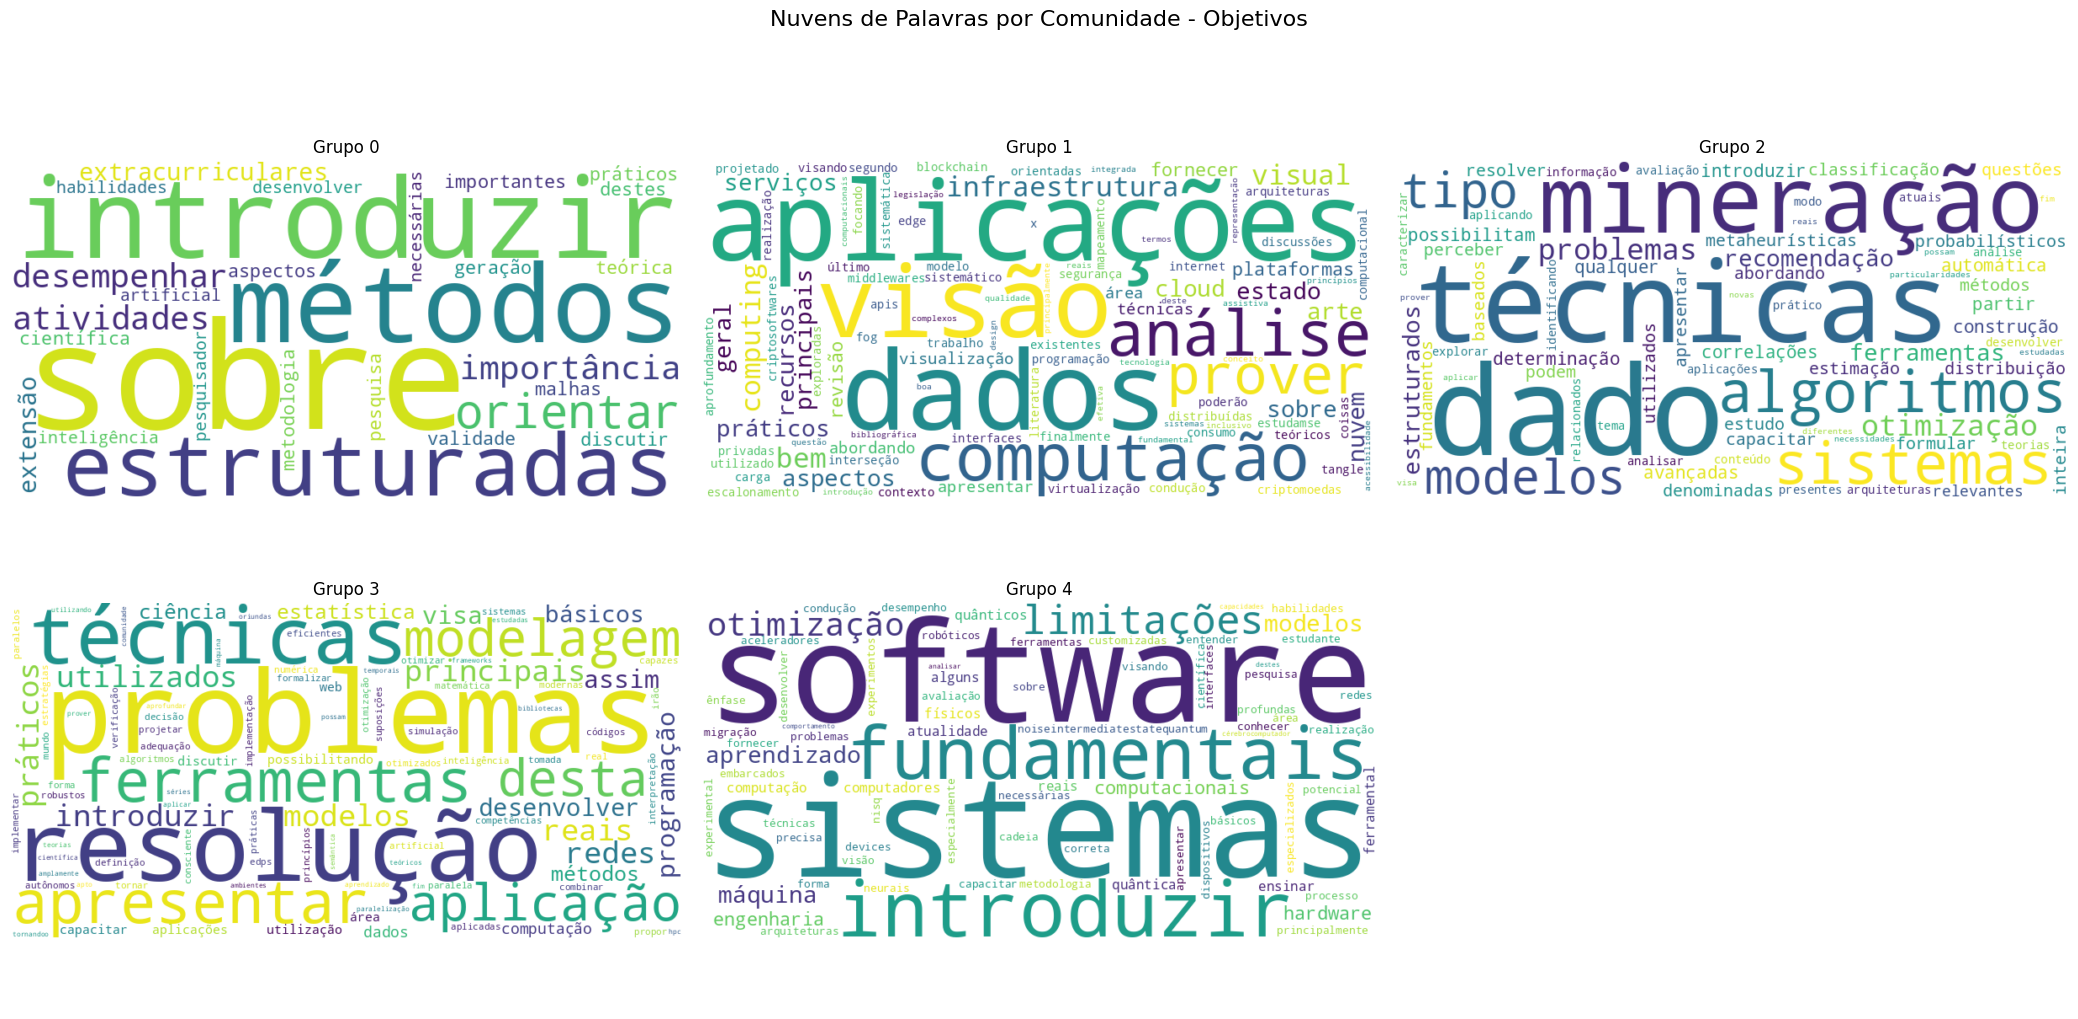


--- Gerando Nuvens para: justificativa (agrupado por comunidade_justificativa) ---
Encontrados 4 grupos: [0, 1, 2, 3]


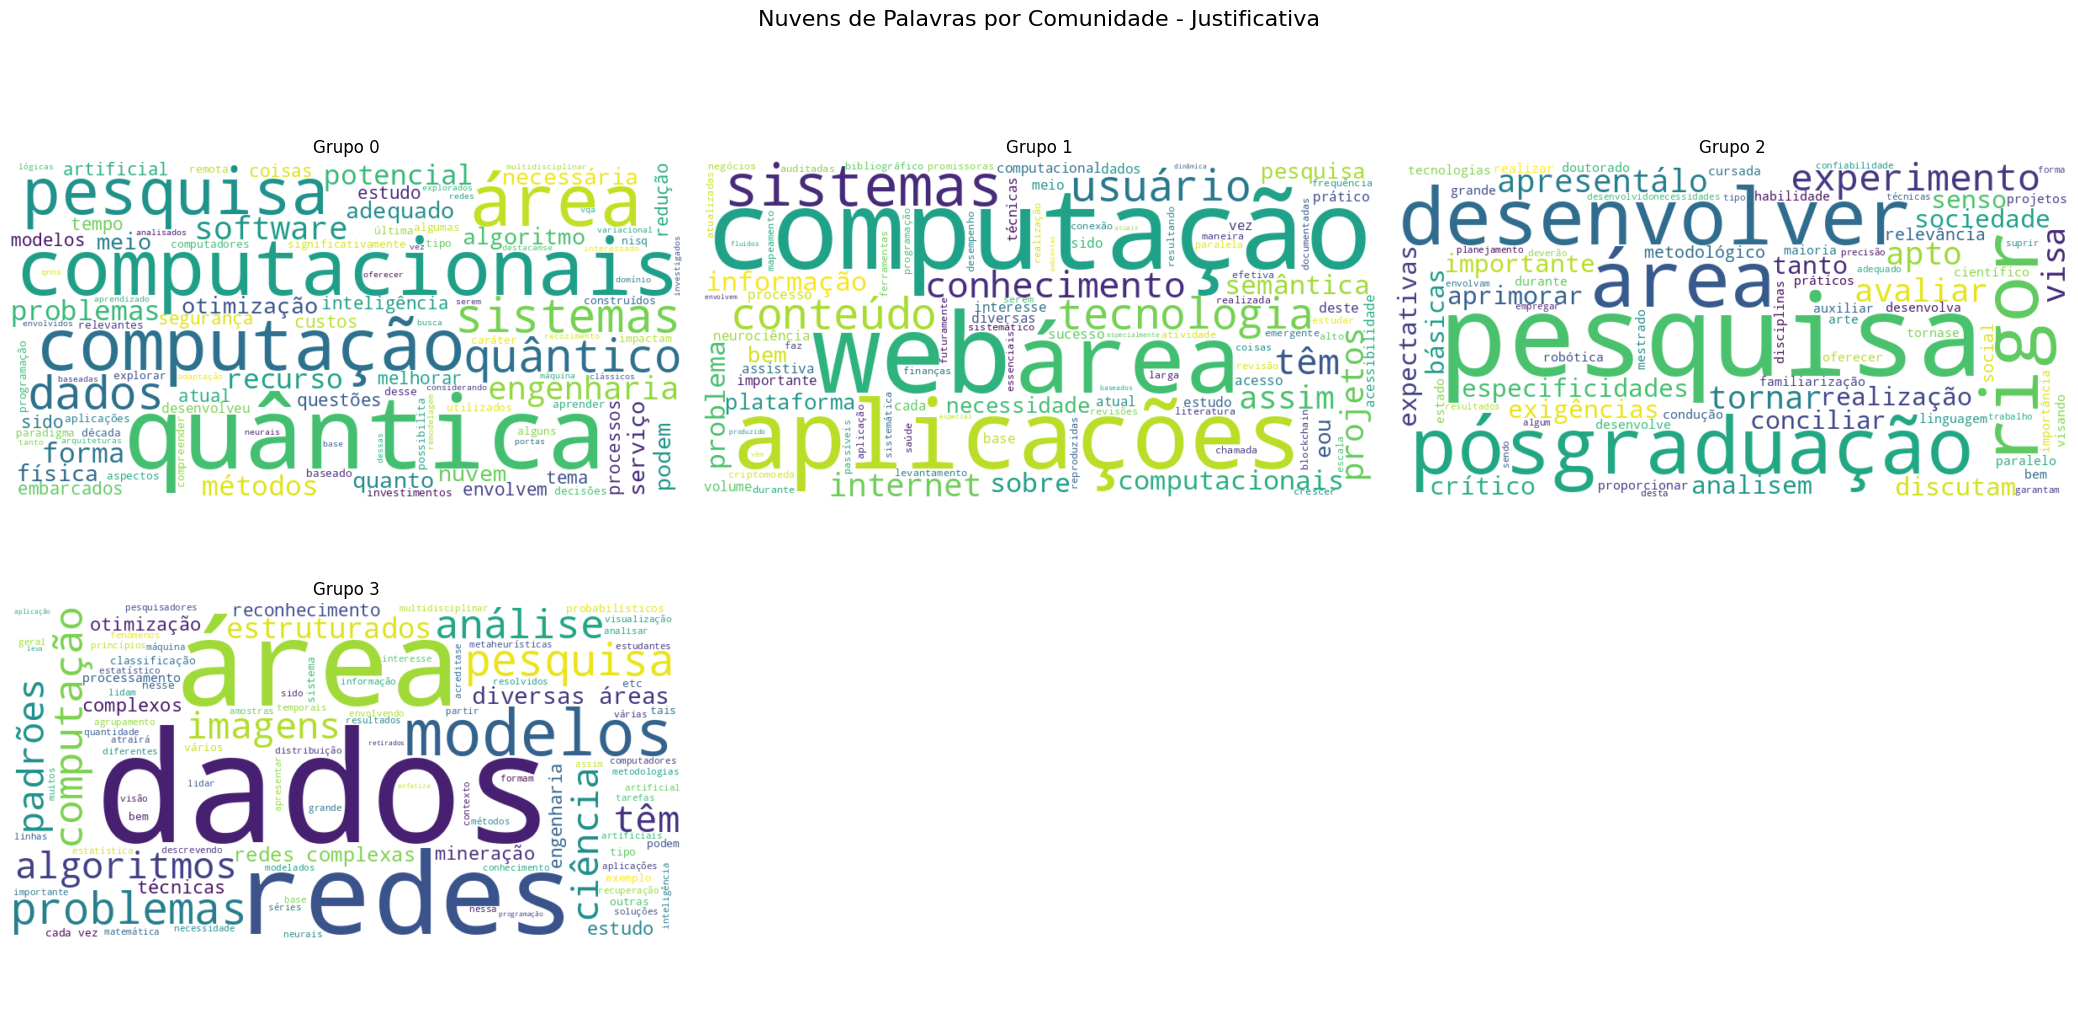


--- Gerando Nuvens para: conteudo (agrupado por comunidade_conteudo) ---
Encontrados 5 grupos: [0, 1, 2, 3, 4]


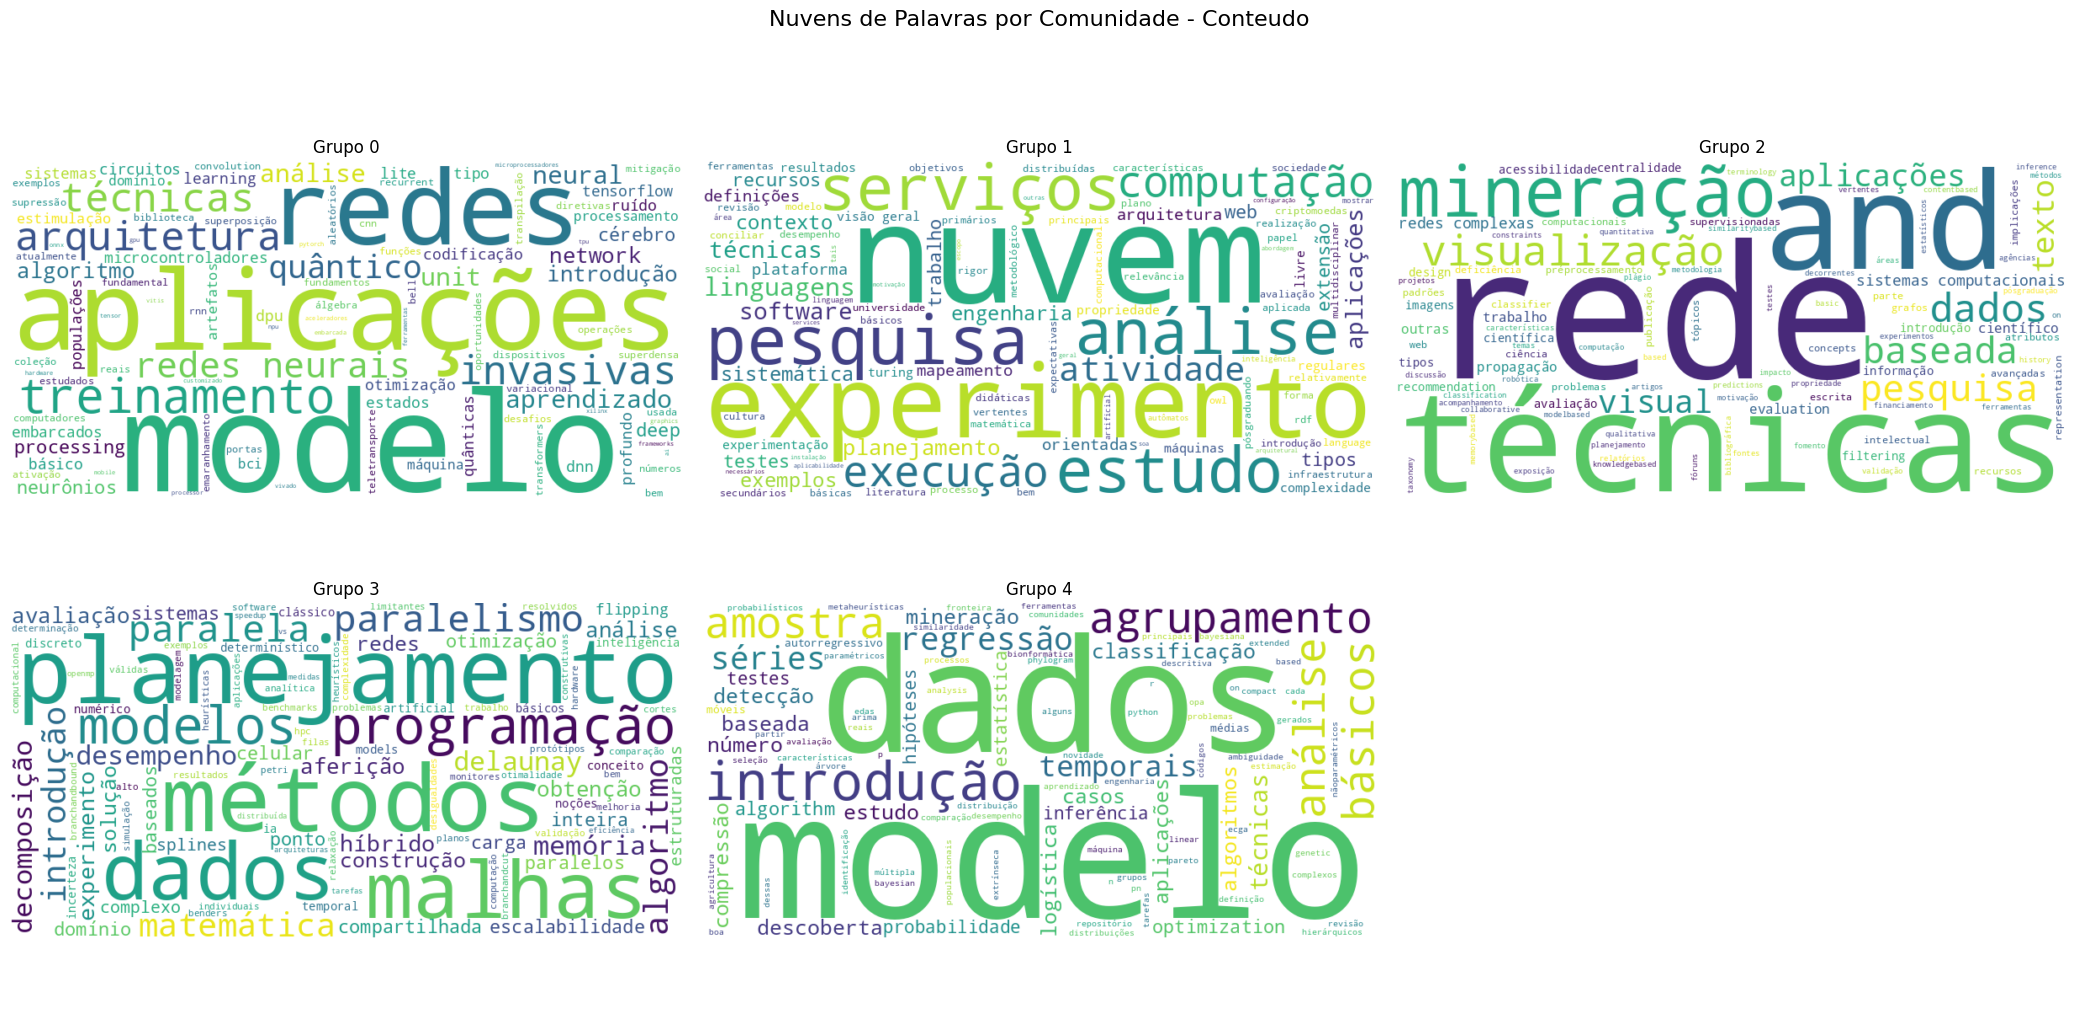

In [23]:
plotar_nuvens_por_grupo(
    df=df_com_comunidades,
    text_col='objetivos',
    group_col='comunidade_objetivos',
    stopwords_set=stopwords_pt
)

# 2. Gerar figura para 'justificativa'
plotar_nuvens_por_grupo(
    df=df_com_comunidades,
    text_col='justificativa',
    group_col='comunidade_justificativa',
    stopwords_set=stopwords_pt
)

# 3. Gerar figura para 'conteudo'
plotar_nuvens_por_grupo(
    df=df_com_comunidades,
    text_col='conteudo',
    group_col='comunidade_conteudo',
    stopwords_set=stopwords_pt
)

## 2ª pergunta

Qual é a representatividade do número de créditos de uma disciplina?
Isto é, o "custo" oficial de uma disciplina, medido em unidades de crédito, reflete seu
"custo" real se for medido pela soma da carga teórica com carga prática e com a carga
de estudo? Para um aluno ingressante ou um professor-orientador elaborar um plano
de estudos, é possível identificar disciplinas cujo custo representa valores críticos que
exigem um esforço desproporcional ao valor de seus créditos?

#### Carga x Créditos

In [24]:
def plotar_creditos_vs_cargas(df: pd.DataFrame,
                              coluna_y: str = 'n_creditos',
                              colunas_carga: list = ['carga_teorica', 'carga_pratica', 'carga_estudo'],
                              coluna_cor: str = None,
                              colunas_hover: list = None,
                              # O ratio não está sendo usado no cálculo da linha y=x,
                              # mas mantenho para não quebrar a assinatura da função
                              credito_ratio: int = 15) -> go.Figure:
    """
    Cria 4 gráficos de dispersão interativos com Plotly e adiciona
    uma linha de referência (ex: 1 crédito = 15 horas).

    Args:
        ... (outros args)
        credito_ratio (int): A relação de horas por crédito (ex: 15).
    """

    # --- 1. Preparação dos Dados ---
    df_plot = df.copy()

    soma_nome = 'carga_total_soma'
    df_plot[soma_nome] = df_plot[colunas_carga].sum(axis=1)

    colunas_x = [soma_nome] + colunas_carga

    titulos_plot = [
        f'{coluna_y} vs. Soma das Cargas',
        f'{coluna_y} vs. {colunas_carga[0]}',
        f'{coluna_y} vs. {colunas_carga[1]}',
        f'{coluna_y} vs. {colunas_carga[2]}'
    ]

    # --- Cálculo da Linha de Referência ---
    # (Baseado no seu código: y = x)
    x_max_geral = df_plot[colunas_x].max().max()

    line_x0 = 0
    line_y0 = 0
    line_x1 = x_max_geral
    line_y1 = x_max_geral # Linha y=x


    # --- 2. Configuração de Hover e Cor ---
    if colunas_hover is None:
        hover_padrao = ['codigo', 'disciplina']
        hover_data_validas = [col for col in hover_padrao if col in df_plot.columns]
        if not hover_data_validas:
            hover_data_validas = list(df_plot.columns[:2])
    else:
        hover_data_validas = [col for col in colunas_hover if col in df_plot.columns]

    cor_valida = None
    cat_order_dict = None
    if coluna_cor and coluna_cor in df_plot.columns:
        cor_valida = coluna_cor
        try:
            categorias_ordenadas = sorted(df_plot[coluna_cor].unique())
        except TypeError:
            categorias_ordenadas = sorted(df_plot[coluna_cor].astype(str).unique())
        cat_order_dict = {coluna_cor: categorias_ordenadas}

    # --- 3. Criação dos Gráficos ---
    plot_args = {
        'y': coluna_y,
        'color': cor_valida,
        'hover_data': hover_data_validas,
        'color_discrete_sequence': PALETA_PAUL_TOL_6,
        'category_orders': cat_order_dict
    }

    fig_soma = px.scatter(df_plot, x=soma_nome, **plot_args)
    fig_c1 = px.scatter(df_plot, x=colunas_carga[0], **plot_args)
    fig_c2 = px.scatter(df_plot, x=colunas_carga[1], **plot_args)
    fig_c3 = px.scatter(df_plot, x=colunas_carga[2], **plot_args)

    fig_final = make_subplots(
        rows=2, cols=2,
        subplot_titles=titulos_plot,
        shared_yaxes=True
    )

    # --- 4. Combinação dos Gráficos ---
    for trace in fig_soma.data:
        fig_final.add_trace(trace, row=1, col=1)

    for trace in fig_c1.data:
        fig_final.add_trace(trace.update(showlegend=False), row=1, col=2)

    for trace in fig_c2.data:
        fig_final.add_trace(trace.update(showlegend=False), row=2, col=1)

    for trace in fig_c3.data:
        fig_final.add_trace(trace.update(showlegend=False), row=2, col=2)

    # --- 5. Layout Final ---
    fig_final.update_layout(
        height=800,
        title_text=f'Relação entre Nº de Créditos e Cargas Horárias',
        legend_title_text=coluna_cor if cor_valida else None,
        xaxis_title=soma_nome,
        xaxis2_title=colunas_carga[0],
        xaxis3_title=colunas_carga[1],
        xaxis4_title=colunas_carga[2],
        yaxis_title=coluna_y,
        yaxis3_title=coluna_y
    )

    fig_final.update_yaxes(tickmode='linear', dtick=2)

    # --- 6. NOVO: Adiciona a Linha de Referência (y = x) com Legenda ---
    # Usamos add_trace (go.Scatter) em vez de add_shape para
    # que a linha apareça na legenda.

    fig_final.add_trace(go.Scatter(
        x=[line_x0, line_x1],
        y=[line_y0, line_y1],
        mode='lines',
        line=dict(color="rgba(255, 0, 0, 0.5)", width=2, dash="dash"),
        name="1 crédito equivale 1 carga de esforço", # <--- SUA LEGENDA
        hoverinfo='none'
    ), row=1, col=1) # Adiciona apenas ao primeiro gráfico, como no seu exemplo

    fig_final.show()
    return fig_final

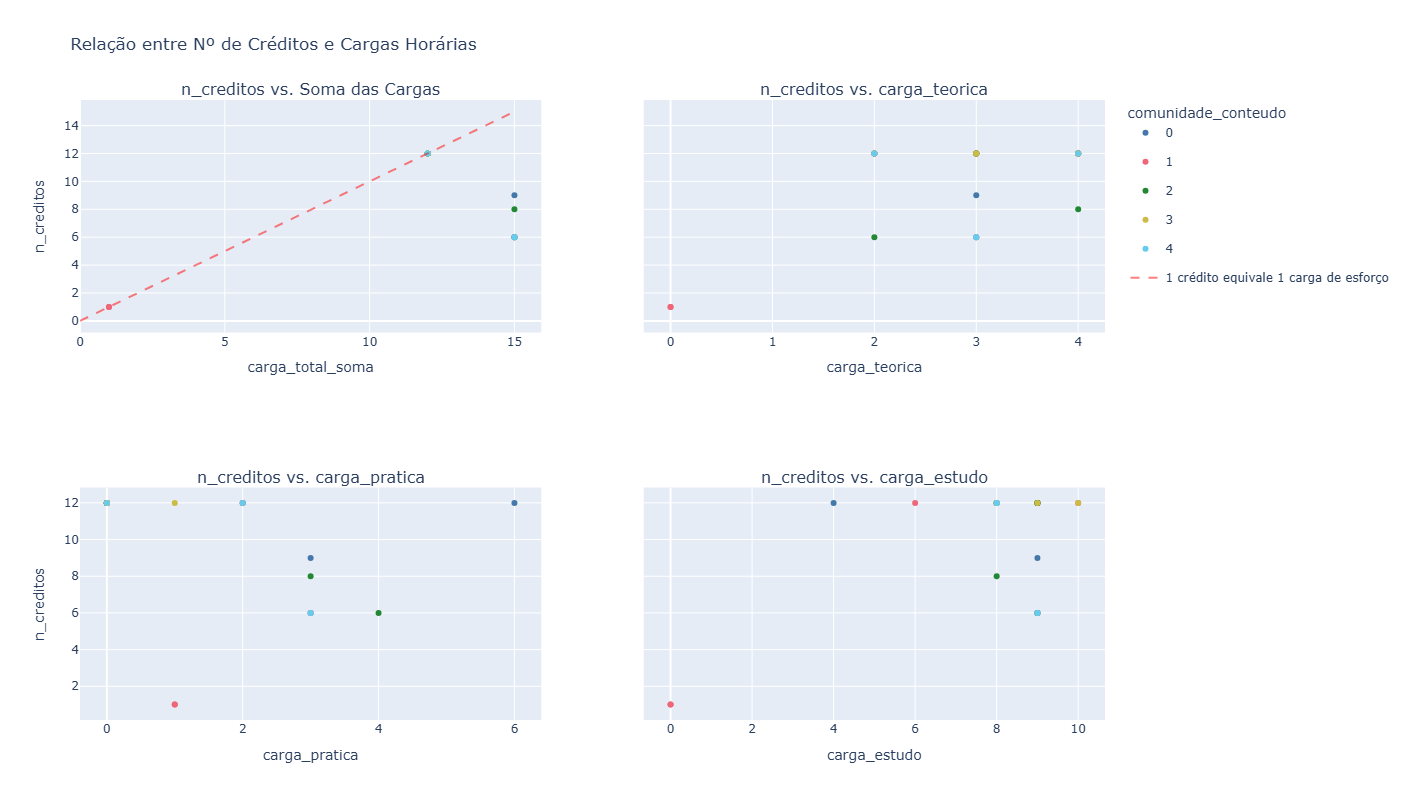

In [25]:
figura_cargas = plotar_creditos_vs_cargas(
    df=df_com_comunidades,
    coluna_y='n_creditos',
    coluna_cor='comunidade_conteudo',
    colunas_hover=['codigo', 'disciplina', 'n_creditos']
)

#### Horas x Créditos

In [26]:
def plotar_creditos_vs_duracao(
    df: pd.DataFrame,
    coluna_y: str = 'n_creditos',
    coluna_x: str = 'duracao',
    coluna_cor: str = None,
    colunas_hover: list = None,
    # --- Novos parâmetros para "Nomes Bonitos" ---
    titulo_x: str = None,
    titulo_y: str = None,
    titulo_grafico: str = None,
    titulo_legenda: str = None
) -> go.Figure:
    """
    Cria 1 gráfico de dispersão interativo com Plotly para
    comparar créditos e duração.
    """

    df_plot = df.copy()

    # --- Lógica de Nomes Bonitos ---

    # Mapa de nomes comuns para formatação automática
    mapa_titulos = {
        'n_creditos': 'Nº de Créditos',
        'duracao': 'Duração da Disciplina (em Horas)',
        'oferecimento': 'Oferecimento',
        'comunidade_objetivos': 'Comunidade (Objetivos)',
        'comunidade_conteudo': 'Comunidade (Conteúdo)',
        'carga_total': 'Carga Total (em Horas)'
    }

    def formatar_titulo(nome_coluna, mapa):
        if nome_coluna in mapa:
            return mapa[nome_coluna]
        if nome_coluna:
            return nome_coluna.replace('_', ' ').capitalize()
        return None

    # Define os títulos finais: usa o override do usuário ou formata o nome da coluna
    titulo_x_final = titulo_x if titulo_x is not None else formatar_titulo(coluna_x, mapa_titulos)
    titulo_y_final = titulo_y if titulo_y is not None else formatar_titulo(coluna_y, mapa_titulos)
    titulo_legenda_final = titulo_legenda if titulo_legenda is not None else formatar_titulo(coluna_cor, mapa_titulos)

    # Define o título principal: usa o override ou gera um
    titulo_grafico_final = titulo_grafico
    if titulo_grafico_final is None:
        titulo_grafico_final = f'Relação entre {titulo_y_final} e {titulo_x_final}'

    # --- Fim da Lógica de Nomes Bonitos ---

    if colunas_hover is None:
        hover_padrao = ['codigo', 'disciplina']
        hover_data_validas = [col for col in hover_padrao if col in df_plot.columns]
        if not hover_data_validas:
            hover_data_validas = list(df_plot.columns[:2])
    else:
        hover_data_validas = [col for col in colunas_hover if col in df_plot.columns]

    cor_valida = None
    cat_order_dict = None
    if coluna_cor and coluna_cor in df_plot.columns:
        cor_valida = coluna_cor
        try:
            categorias_ordenadas = sorted(df_plot[coluna_cor].unique())
        except TypeError:
            categorias_ordenadas = sorted(df_plot[coluna_cor].astype(str).unique())
        cat_order_dict = {coluna_cor: categorias_ordenadas}

    # --- Criação do Gráfico ---
    plot_args = {
        'x': coluna_x,
        'y': coluna_y,
        'color': cor_valida,
        'hover_data': hover_data_validas,
        'color_discrete_sequence': PALETA_PAUL_TOL_6,
        'category_orders': cat_order_dict,
        'title': titulo_grafico_final # <-- Usa o título bonito
    }

    fig_final = px.scatter(df_plot, **plot_args)

    # --- Layout Final ---
    fig_final.update_layout(
        height=600,
        legend_title_text=titulo_legenda_final, # <-- Usa o título bonito
        xaxis_title=titulo_x_final,           # <-- Usa o título bonito
        yaxis_title=titulo_y_final            # <-- Usa o título bonito
    )

    fig_final.update_yaxes(tickmode='linear', dtick=2)

    fig_final.show()
    return fig_final

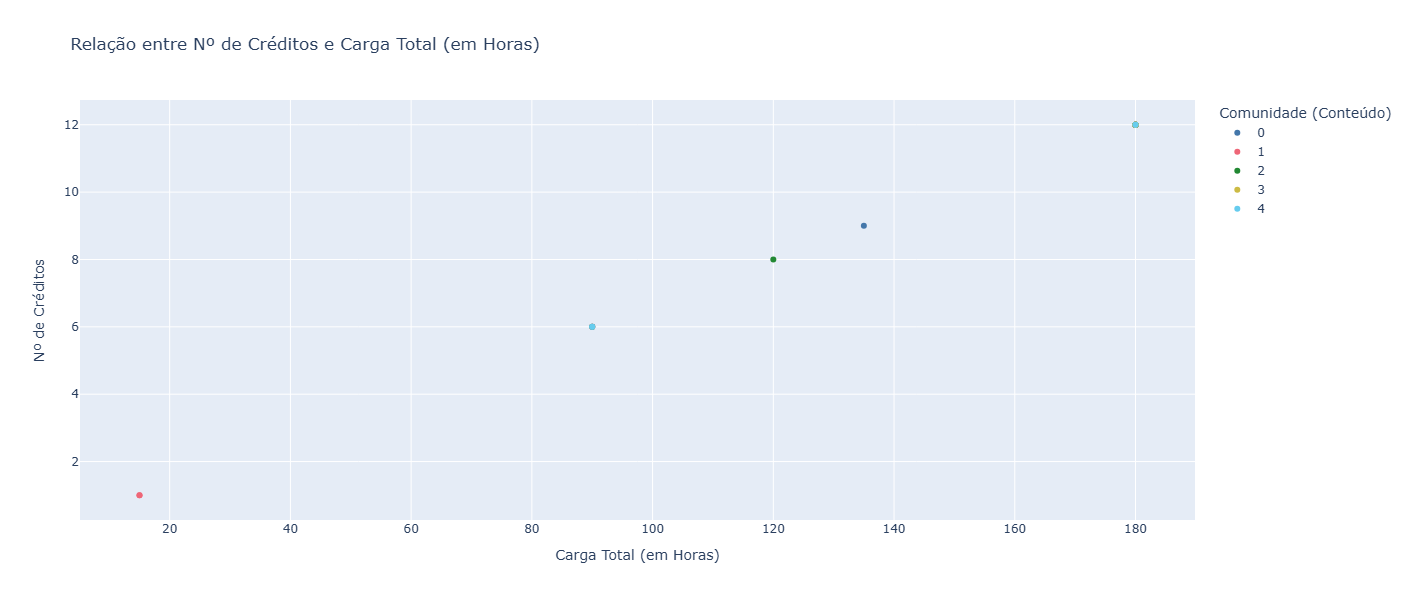

In [27]:
figura_cargas = plotar_creditos_vs_duracao(
    df=df_com_comunidades,
    coluna_y='n_creditos',
    coluna_x='carga_total',
    coluna_cor='comunidade_conteudo',
    colunas_hover=['codigo', 'disciplina', 'n_creditos']
)

## 3ª pergunta

Como o corpo docente se conecta ao currículo? É possível mapear quais professores são responsáveis por quais disciplinas, de forma a revelar as principais frentes de atuação de cada docente e identificar professores-chave que conectam diferentes áreas temáticas do programa?

#### Grafo Bipartido

In [28]:
def cria_grafo_bipartido(df):
    """
    Cria um grafo bipartido (Disciplinas <-> Docentes) a partir do DataFrame.
    """
    df_proc = df.copy()
    df_proc.dropna(subset=['docentes_responsaveis'], inplace=True)

    df_temp = df_proc.assign(
        docente_str=df_proc['docentes_responsaveis'].str.replace(' | ', ',', regex=False)
    )
    df_exploded = df_temp.assign(
        docente=df_temp['docente_str'].str.split(',')
    ).explode('docente')

    df_exploded = df_exploded[df_exploded.docente != '']

    df_exploded['docente'] = df_exploded['docente'].str.strip()

    B = nx.Graph()

    disciplinas_unicas = df_exploded[[
        'codigo', 'disciplina', 'comunidade_conteudo'
    ]].drop_duplicates()

    for _, row in disciplinas_unicas.iterrows():
        B.add_node(
            row['codigo'],
            bipartite=0,
            type='disciplina',
            nome_disciplina=row['disciplina'],
            comunidade=row['comunidade_conteudo']
        )

    docentes_unicos = df_exploded['docente'].unique()
    for docente in docentes_unicos:
        B.add_node(
            docente,
            bipartite=1,
            type='docente'
        )

    edges_list = list(zip(df_exploded['codigo'], df_exploded['docente']))
    B.add_edges_from(edges_list)

    return B

# --- Função 2: Plotagem com Plotly (MODIFICADA) ---

def plota_grafo_plotly(G):
    """
    Plota um grafo bipartido do NetworkX usando Plotly e exibe o gráfico.

    *** NOVO: Usa um layout 'shell' (radial) com disciplinas no centro. ***

    - Colore nós do Tipo A (disciplina) por 'comunidade'.
    - Usa triângulos para nós do Tipo B (docente).
    - Configura hovers personalizados.
    - Exibe o gráfico interativo diretamente.
    """

    # 1. Separar os conjuntos de nós
    nodes_A = {n for n, d in G.nodes(data=True) if d.get('bipartite') == 0}
    nodes_B = {n for n, d in G.nodes(data=True) if d.get('bipartite') == 1}

    if not nodes_A or not nodes_B:
        print("Grafo inválido para layout. Um dos conjuntos de nós está vazio.")
        pos = nx.spring_layout(G) # Layout de fallback
    else:
        # 2. *** MODIFICAÇÃO AQUI ***
        #    Calcula o layout em "cascas" (shell).
        #    Primeira lista: centro (Disciplinas)
        #    Segunda lista: periferia (Docentes)
        pos = nx.shell_layout(G, [list(nodes_A), list(nodes_B)])

    # 3. Criar a "figura" base do Plotly
    fig = go.Figure()

    # 4. Adicionar a Trilha de Arestas (Edges)
    edge_x = []
    edge_y = []
    for edge in G.edges():
        if edge[0] not in pos or edge[1] not in pos: continue
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        mode='lines',
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        name='Ligações'
    ))

    # 5. Preparar dados dos Nós para Plotly
    nodes_A_data = {'x': [], 'y': [], 'text': [], 'comunidade': [], 'label': []}
    nodes_B_data = {'x': [], 'y': [], 'text': [], 'label': []}

    for node, data in G.nodes(data=True):
        if node not in pos: continue

        x, y = pos[node]
        node_bipartite = data.get('bipartite', -1)

        if node_bipartite == 0: # Tipo A (Disciplina)
            nodes_A_data['x'].append(x)
            nodes_A_data['y'].append(y)
            nodes_A_data['label'].append(node)
            nodes_A_data['comunidade'].append(data.get('comunidade', 'N/A'))
            nodes_A_data['text'].append(
                f"<b>{node}</b><br>Disciplina: {data.get('nome_disciplina', 'N/A')}<br>Comunidade: {data.get('comunidade', 'N/A')}"
            )
        elif node_bipartite == 1: # Tipo B (Docente)
            nodes_B_data['x'].append(x)
            nodes_B_data['y'].append(y)
            nodes_B_data['label'].append(node)
            nodes_B_data['text'].append(f"<b>Docente:</b><br>{node}")

    # 6. Adicionar Trilha dos Nós Tipo B (Docentes) - Periferia
    if nodes_B_data['x']:
        fig.add_trace(go.Scatter(
            x=nodes_B_data['x'], y=nodes_B_data['y'],
            text=nodes_B_data['text'],
            mode='markers',
            hoverinfo='text',
            name='Docentes',
            marker=dict(symbol='triangle-up', size=14, color='#666')
        ))

    # 7. Adicionar Trilhas dos Nós Tipo A (Disciplinas) - Centro
    if nodes_A_data['x']:
        df_nodes_A = pd.DataFrame(nodes_A_data)
        colors = px.colors.qualitative.Plotly
        comunidades_unicas = sorted(df_nodes_A['comunidade'].unique())

        for i, comunidade in enumerate(comunidades_unicas):
            df_subset = df_nodes_A[df_nodes_A['comunidade'] == comunidade]
            fig.add_trace(go.Scatter(
                x=df_subset['x'], y=df_subset['y'],
                text=df_subset['text'],
                mode='markers',
                hoverinfo='text',
                name=f'{comunidade}',
                marker=dict(symbol='circle', size=14, color=colors[i % len(colors)])
            ))

    # 8. Limpar o layout do gráfico
    fig.update_layout(
        # *** Título modificado para refletir o novo layout ***
        title='Grafo Radial: Disciplinas (Centro) e Docentes (Periferia)',
        showlegend=True,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        legend_title_text='Legenda'
    )

    # 9. Exibe o gráfico
    print("Exibindo o gráfico Plotly (Layout Radial)...")
    fig.show()
    fig.write_image("grafo-bipartido.png")

    return fig # Retorna o objeto da figura


Informações do Grafo Criado:
Total de Nós: 69
  - Nós Tipo A (Disciplinas): 23
  - Nós Tipo B (Docentes): 46
Total de Arestas (Ligações): 67
------------------------------
Exibindo o gráfico Plotly (Layout Radial)...


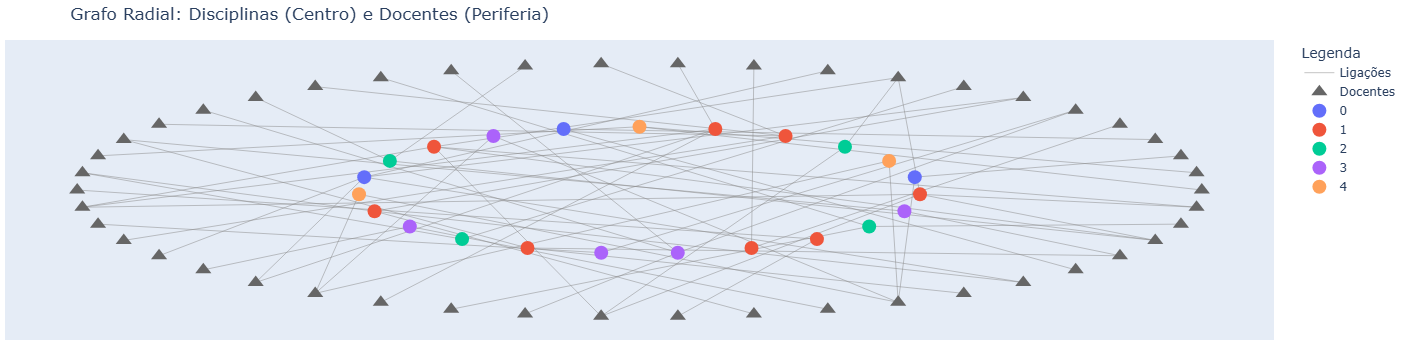


Arquivo Plotly criado com sucesso.


In [29]:
G = cria_grafo_bipartido(df_com_comunidades)

nodes_A_count = sum(1 for n, d in G.nodes(data=True) if d.get('bipartite') == 0)
nodes_B_count = sum(1 for n, d in G.nodes(data=True) if d.get('bipartite') == 1)

print("\nInformações do Grafo Criado:")
print(f"Total de Nós: {G.number_of_nodes()}")
print(f"  - Nós Tipo A (Disciplinas): {nodes_A_count}")
print(f"  - Nós Tipo B (Docentes): {nodes_B_count}")
print(f"Total de Arestas (Ligações): {G.number_of_edges()}")
print("-" * 30)

# 4. Plotar o grafo
if G.number_of_nodes() > 0:
    json_file = plota_grafo_plotly(G)
    print(f"\nArquivo Plotly criado com sucesso.")
else:
    print("\nGrafo vazio. Nenhum arquivo de plotagem foi gerado.")

#### Atividade dos Docentes

In [30]:
# =============================================================================
# FUNÇÃO 1: Preparação dos Dados (Extraída da sua função de grafo)
# =============================================================================
def prepara_dados_docentes(df):
    """
    Processa o DataFrame para explodir a lista de docentes.
    Esta é a base que precisamos para o gráfico de barras.
    """
    df_proc = df.copy()
    df_proc.dropna(subset=['docentes_responsaveis'], inplace=True)

    df_temp = df_proc.assign(
        docente_str=df_proc['docentes_responsaveis'].str.replace(' | ', ',', regex=False)
    )
    df_exploded = df_temp.assign(
        docente=df_temp['docente_str'].str.split(',')
    ).explode('docente')

    df_exploded = df_exploded[df_exploded.docente != '']
    df_exploded['docente'] = df_exploded['docente'].str.strip()

    # Remove duplicatas caso um docente esteja listado mais de uma vez
    # na *mesma* disciplina (embora o explode já deva lidar com isso)
    df_final = df_exploded[['docente', 'codigo', 'comunidade_conteudo']].drop_duplicates()

    return df_final



In [31]:
# =============================================================================
# FUNÇÃO 2: Gráfico de Barras Empilhadas (MODIFICADA)
# =============================================================================

def plota_contagem_docentes(df_processado):
    """
    Cria um gráfico de barras horizontais (docentes no eixo Y, contagem no X)
    com as barras empilhadas pela comunidade da disciplina.

    MODIFICAÇÕES:
    - Adicionado 'height' e 'width' em update_layout para um tamanho maior.
    - A ordem crescente (ascending=True) já estava implementada.
    """

    # 1. Agrupar por docente e comunidade para obter a contagem
    df_agregado = df_processado.groupby(
        ['docente', 'comunidade_conteudo']
    ).size().reset_index(name='contagem')

    # 2. Ordenar o eixo Y pelo total de disciplinas
    #    Calcula o total por docente
    #    'ascending=True' garante a ORDEM CRESCENTE (do menor para o maior)
    df_total = df_agregado.groupby('docente')['contagem'].sum().sort_values(ascending=False)

    # 3. Criar o gráfico de barras com Plotly Express
    fig = px.bar(
        df_agregado,
        # Docentes no eixo Y
        y='docente',
        # Contagem no eixo X
        x='contagem',
        # Empilhar (colorir) pela comunidade
        color='comunidade_conteudo',
        # Forçar orientação horizontal
        orientation='h',
        title='Número de Disciplinas por Docente (por Comunidade)',
        # Ordenar o eixo Y com base no total calculado
        category_orders={'docente': df_total.index.tolist()},
        labels={
            'docente': 'Docente',
            'contagem': 'Número de Disciplinas',
            'comunidade_conteudo': 'Comunidade'
        },
        # Texto para o hover
        hover_data={'docente': True, 'comunidade_conteudo': True, 'contagem': True}
    )

    # Garante que o modo de barra seja 'empilhado' (stack)
    # e define um tamanho maior para a figura
    fig.update_layout(
        barmode='stack',
        height=1600,
        width=1000
    )

    # Exibe o gráfico
    fig.show()
    fig.write_image("docentes.png")
    return fig

/tmp/ipykernel_3680/107669169.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



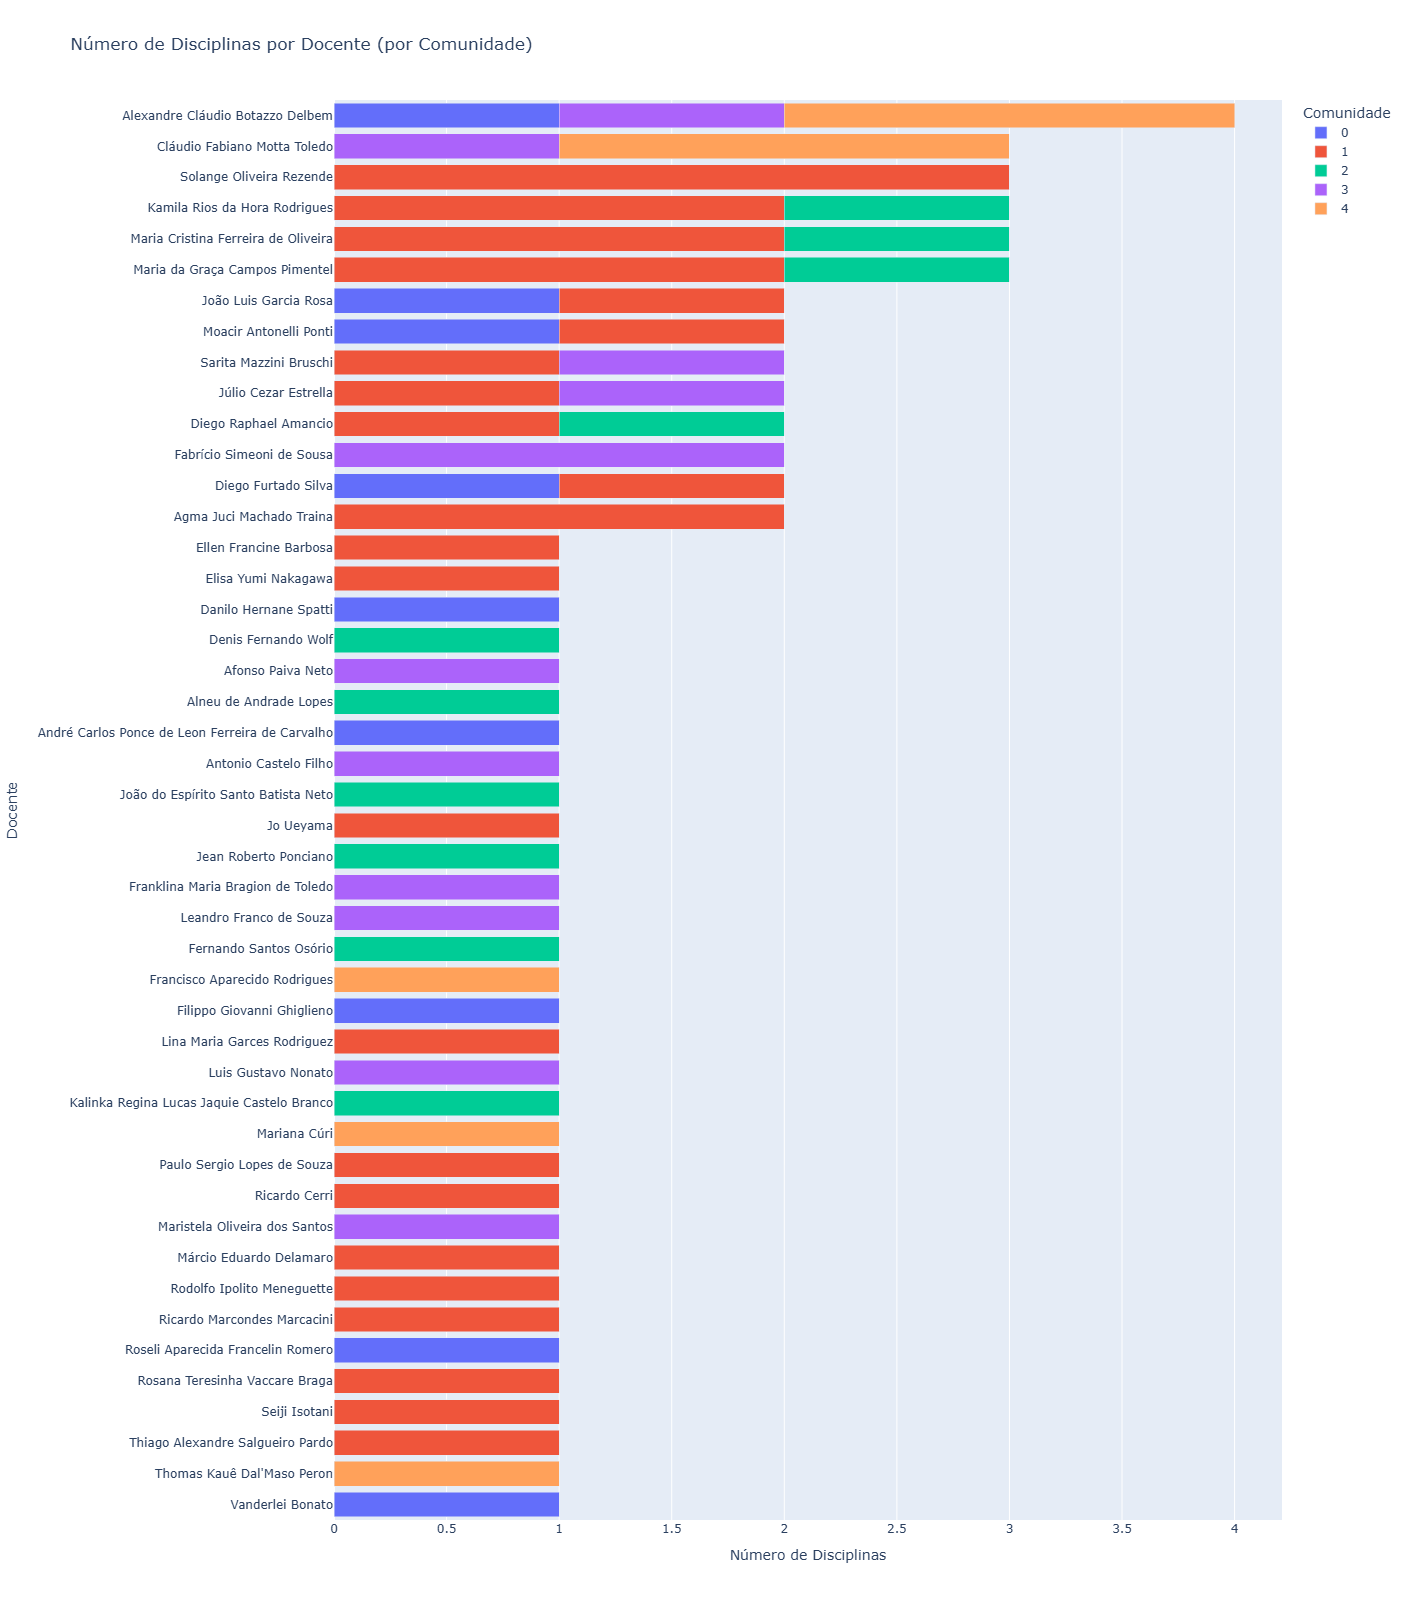

In [32]:
dados_plotagem = prepara_dados_docentes(df_com_comunidades)

fig = plota_contagem_docentes(dados_plotagem)